In [1]:
# install packages
! pip install networkx==3.1

# load environment
from networkx.algorithms.community import louvain_communities, modularity
from sklearn import metrics

import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import scipy
import seaborn as sns
import statistics

# set seed
np.random.seed(611)
random.seed(611)
random_state = np.random.RandomState(611)


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
# define global variables
LABELS_COMPARISONS = [
    'Control vs. PE',
    'Control vs. PTD',
    'Control vs. FGR',
    'Control vs. FGR+HDP',
    'PE vs. PTD',
    'PE vs. FGR',
    'PE vs. FGR+HDP',
    'PTD vs. FGR',
    'PTD vs. FGR+HDP',
    'FGR vs. FGR+HDP',
]
LABELS_GROUPS = [
    'Control',
    'PE',
    'PTD',
    'FGR',
    'FGR+HDP',
]
RESOLUTION = 0.45
SEED = 611

In [3]:
def calculate_modularity(G):
    comm = louvain_communities(G, weight='coef', resolution=RESOLUTION, seed=SEED)
    mod = round(modularity(G, comm, weight='coef', resolution=RESOLUTION),2)
    return mod


def calculate_jaccard_index(graph1, graph2, eval_nodes=True):
    
    if eval_nodes:
        # Convert graphs to sets of nodes
        set1 = set(graph1.nodes)
        set2 = set(graph2.nodes)
    else:
        # Convert graphs to sets of edges
        set1 = set(graph1.edges)
        set2 = set(graph2.edges)

    # Calculate Jaccard index
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_index = round(intersection / union, 3)
    return jaccard_index


def generate_labels_for_communities(comm):
    d = {}
    count = 0
    for c in comm:
        for item in c:
            d[item] = count
        count += 1
    return d


def convert_community_structure_to_labels(G):
    labels = []
    comm = louvain_communities(G, weight='analyte2', resolution=RESOLUTION, seed=SEED)
    d = generate_labels_for_communities(comm)
    for node in G.nodes():
        labels.append(d[node])
    return labels


def calculate_adjusted_mutual_info_score(graph1, graph2):
    
    # Convert community structures to label assignments
    labels1 = convert_community_structure_to_labels(graph1)
    labels2 = convert_community_structure_to_labels(graph2)
    
    # Calculate adjusted NMI
    nmi = round(metrics.adjusted_mutual_info_score(labels1, labels2), 3)
    return nmi


def calculate_adjusted_rand_score(graph1, graph2):
    
    # Convert community structures to label assignments
    labels1 = convert_community_structure_to_labels(graph1)
    labels2 = convert_community_structure_to_labels(graph2)
    
    # Calculate adjusted rand score
    rand_score = round(metrics.adjusted_rand_score(labels1, labels2), 3)
    return rand_score


def calc_difference(item1, item2):
    result = round((item1 - item2),3)
    return result


def calc_avg(l):
    if len(l) > 0:      
        return sum(l)/len(l)
    return 0


def calc_stdev(l):
    if len(l) > 0:      
        return statistics.stdev(l)
    return 0


def add_n_items_to_list(n, value):
    l = []
    for i in range(n):
        l.append(value)
    return l


def calc_avg_shortest_path(G, group):
    # Calculate the average path length for each component
    list_avg_path_length = []
    print('Average Shortest Path For Communities in', group)
    count = 0
    comm = louvain_communities(G, weight='analyte2', resolution=RESOLUTION, seed=SEED)
    for component in comm:
        component_graph = G.subgraph(component)
        avg_path_length = nx.average_shortest_path_length(component_graph)
        print('Community' + str(count) + ': ' + str(avg_path_length))
        l_temp = add_n_items_to_list(len(component), avg_path_length)
        list_avg_path_length.extend(l_temp)
        count+=1
    avg = calc_avg(list_avg_path_length)
    if len(list_avg_path_length) > 1:
        sd = calc_stdev(list_avg_path_length)
    else:
        sd = 0
    return avg, sd


def calc_avg_degree_centrality(G, group):
    print('Average Degree Centrality For Communities in', group)
    list_degree_centrality = []
    comm = louvain_communities(G, weight='analyte2', resolution=RESOLUTION, seed=SEED)
    for component in comm:
        component_graph = G.subgraph(component)
        component_degree_centrality = nx.degree_centrality(component_graph)
        list_degree_centrality.extend(component_degree_centrality.values())
    avg = calc_avg(list_degree_centrality)
    if len(list_degree_centrality) > 1:
        sd = calc_stdev(list_degree_centrality)
    else:
        sd = 0
    return avg, sd
            

def calc_partition_quality(G, group):
    list_partition_quality = []
    comm = louvain_communities(G, weight='analyte2', resolution=RESOLUTION, seed=SEED)
    partition = [list(community) for community in comm]
    quality = nx.community.partition_quality(G, partition)
    print(group + ' Coverage: ' + str(quality[0]))
    print(group + ' Performance: ' + str(quality[1]))
    print('\n')
    return quality


def eval_comm_size(G, group):
    l_size = []
    comm = louvain_communities(G, weight='analyte2', resolution=RESOLUTION, seed=SEED)
    for c in comm:
        l_size.append(len(c))
    avg = calc_avg(l_size)
    if len(l_size) > 1:
        sd = calc_stdev(l_size)
    else:
        sd = 0
    print(group + ' Community Average Size: ' + str(avg))
    print(group + ' Community Size Standard Deviation: ' + str(sd))
    print('\n')
    return avg, sd


def get_community_subgraph(G, analyte):
    comm = louvain_communities(G, weight='analyte2', resolution=RESOLUTION, seed=SEED)
    for component in comm:
        if analyte in component:
            component_graph = G.subgraph(component)
            return component_graph
    return nx.Graph()

In [4]:
g_control = nx.read_gml('../output/control/community_structure.sig_edges.gml')
g_ptd = nx.read_gml('../output/ptd/community_structure.sig_edges.gml')
g_severe_pe = nx.read_gml('../output/severePE/community_structure.sig_edges.gml')
g_fgr = nx.read_gml('../output/fgr/community_structure.sig_edges.gml')
g_fgr_hyp = nx.read_gml('../output/fgr+hyp/community_structure.sig_edges.gml')

In [5]:
# evaluate size communities
l_avg_size = []
l_size_sd = []

print('Community Statistics:\n')

avg, sd = eval_comm_size(g_control, 'Control')
l_avg_size.append(avg)
l_size_sd.append(sd)

avg, sd = eval_comm_size(g_severe_pe, 'PE')
l_avg_size.append(avg)
l_size_sd.append(sd)

avg, sd = eval_comm_size(g_ptd, 'PTD')
l_avg_size.append(avg)
l_size_sd.append(sd)

avg, sd = eval_comm_size(g_fgr, 'FGR')
l_avg_size.append(avg)
l_size_sd.append(sd)

avg, sd = eval_comm_size(g_fgr_hyp, 'FGR+HDP')
l_avg_size.append(avg)
l_size_sd.append(sd)

Community Statistics:

Control Community Average Size: 29.92105263157895
Control Community Size Standard Deviation: 93.33936384026443


PE Community Average Size: 441.1666666666667
PE Community Size Standard Deviation: 1401.8375440827656


PTD Community Average Size: 340.6666666666667
PTD Community Size Standard Deviation: 725.6066218668141


FGR Community Average Size: 7.0
FGR Community Size Standard Deviation: 7.503845168158276


FGR+HDP Community Average Size: 357.0
FGR+HDP Community Size Standard Deviation: 502.04581464244876




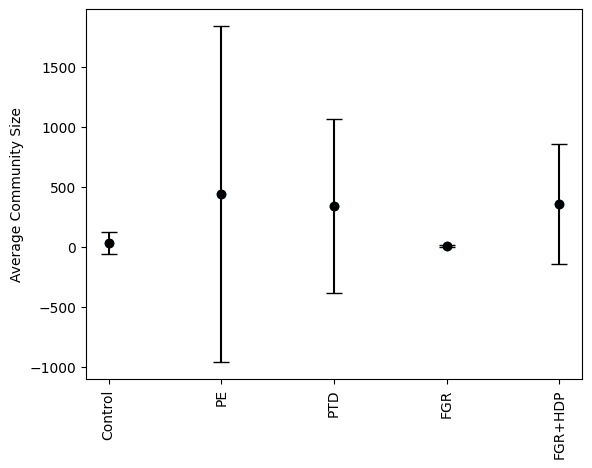

In [6]:
plt.plot(l_avg_size, marker='o', linestyle='')
plt.errorbar([0,1,2,3,4], l_avg_size, yerr=l_size_sd, fmt="o", color='black', capsize=6)
plt.xticks(ticks=range(0, len(l_avg_size)),labels=LABELS_GROUPS, rotation=90)
plt.ylabel('Average Community Size')
plt.savefig("../output/CommunityConservationAnalysis/average_community_size_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
# calculate node jacard similarity index
jaccard_similarity_coefficient = []

print('Node Jacard Similarity Index:\n')

jaccard_index = calculate_jaccard_index(g_control, g_severe_pe)
jaccard_similarity_coefficient.append(jaccard_index)
print('Control vs. PE:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_control, g_ptd)
jaccard_similarity_coefficient.append(jaccard_index)
print('Control vs. PTD:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_control, g_fgr)
jaccard_similarity_coefficient.append(jaccard_index)
print('Control vs. FGR:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_control, g_fgr_hyp)
jaccard_similarity_coefficient.append(jaccard_index)
print('Control vs. FGR+HDP:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_severe_pe, g_ptd)
jaccard_similarity_coefficient.append(jaccard_index)
print('PE vs. FTD:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_severe_pe, g_fgr)
jaccard_similarity_coefficient.append(jaccard_index)
print('PE vs. FGR:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_severe_pe, g_fgr_hyp)
jaccard_similarity_coefficient.append(jaccard_index)
print('PE vs. FGR+HDP:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_ptd, g_fgr)
jaccard_similarity_coefficient.append(jaccard_index)
print('PTD vs. FGR:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_ptd, g_fgr_hyp)
jaccard_similarity_coefficient.append(jaccard_index)
print('PTD vs. FGR+HDP:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_fgr, g_fgr_hyp)
jaccard_similarity_coefficient.append(jaccard_index)
print('FGR vs. FGR+HDP:', str(jaccard_index))

Node Jacard Similarity Index:

Control vs. PE: 0.132
Control vs. PTD: 0.149
Control vs. FGR: 0.017
Control vs. FGR+HDP: 0.035
PE vs. FTD: 0.39
PE vs. FGR: 0.011
PE vs. FGR+HDP: 0.046
PTD vs. FGR: 0.012
PTD vs. FGR+HDP: 0.073
FGR vs. FGR+HDP: 0.006


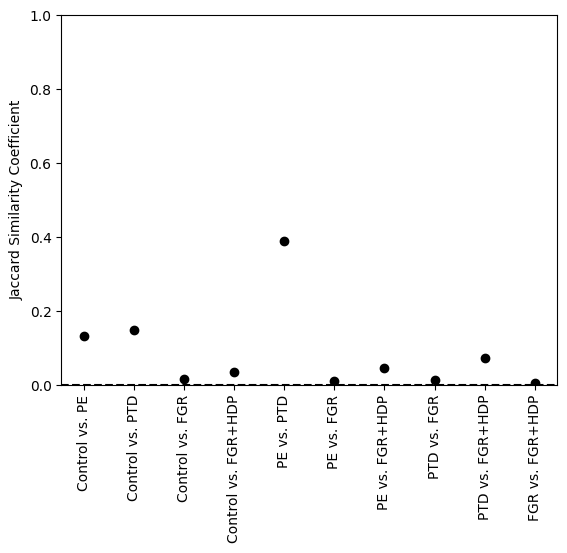

In [8]:
plt.plot(jaccard_similarity_coefficient, marker='o', linestyle='', color='black')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.xticks(ticks=range(0, len(jaccard_similarity_coefficient)),labels=LABELS_COMPARISONS, rotation=90)
plt.ylim((0,1))
plt.ylabel('Jaccard Similarity Coefficient')
plt.savefig("../output/CommunityConservationAnalysis/jaccard_similarity_coefficient_nodes_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [9]:
# calculate edge jacard similarity index
jaccard_similarity_coefficient = []

print('Edge Jacard Similarity Index:\n')

jaccard_index = calculate_jaccard_index(g_control, g_severe_pe, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('Control vs. PE:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_control, g_ptd, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('Control vs. PTD:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_control, g_fgr, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('Control vs. FGR:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_control, g_fgr_hyp, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('Control vs. FGR+HDP:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_severe_pe, g_ptd, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('PE vs. PTD:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_severe_pe, g_fgr, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('PE vs. FGR:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_severe_pe, g_fgr_hyp, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('PE vs. FGR+HDP:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_ptd, g_fgr, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('PTD vs. FGR:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_ptd, g_fgr_hyp, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('PTD vs. FGR+HDP:', str(jaccard_index))

jaccard_index = calculate_jaccard_index(g_fgr, g_fgr_hyp, eval_nodes=False)
jaccard_similarity_coefficient.append(jaccard_index)
print('FGR vs. FGR+HDP:', str(jaccard_index))

Edge Jacard Similarity Index:

Control vs. PE: 0.01
Control vs. PTD: 0.025
Control vs. FGR: 0.0
Control vs. FGR+HDP: 0.0
PE vs. PTD: 0.036
PE vs. FGR: 0.0
PE vs. FGR+HDP: 0.002
PTD vs. FGR: 0.0
PTD vs. FGR+HDP: 0.002
FGR vs. FGR+HDP: 0.0


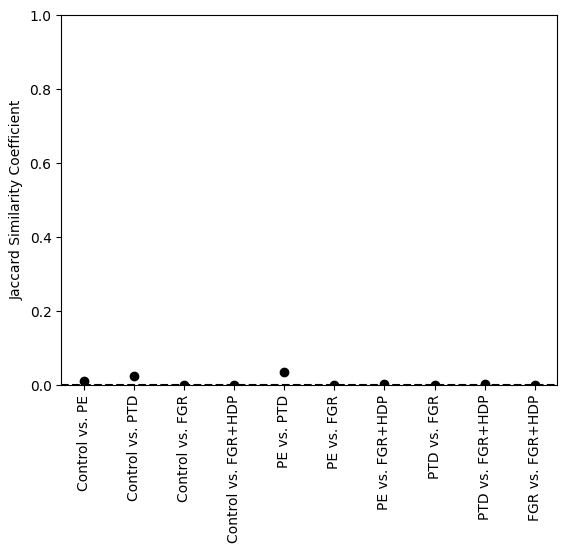

In [10]:
plt.plot(jaccard_similarity_coefficient, marker='o', linestyle='', color = 'black')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.xticks(ticks=range(0, len(jaccard_similarity_coefficient)),labels=LABELS_COMPARISONS, rotation=90)
plt.ylim((0,1))
plt.ylabel('Jaccard Similarity Coefficient')
plt.savefig("../output/CommunityConservationAnalysis/jaccard_similarity_coefficient_edges_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [11]:
# calculate average shortest path length
list_avg_short_path = []
list_avg_short_path_sd = []

print('Average Shortest Path:\n')
print('Control')
avg, sd = calc_avg_shortest_path(g_control, 'Control')
list_avg_short_path.append(avg)
list_avg_short_path_sd.append(sd)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

print('PE')
avg, sd = calc_avg_shortest_path(g_severe_pe, 'PE')
list_avg_short_path.append(avg)
list_avg_short_path_sd.append(sd)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

print('PTD')
avg, sd = calc_avg_shortest_path(g_ptd, 'PTD')
list_avg_short_path.append(avg)
list_avg_short_path_sd.append(sd)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

print('FGR')
avg, sd = calc_avg_shortest_path(g_fgr, 'FGR')
list_avg_short_path.append(avg)
list_avg_short_path_sd.append(sd)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

print('FGR+HDP')
avg, sd = calc_avg_shortest_path(g_fgr_hyp, 'FGR+HDP')
list_avg_short_path.append(avg)
list_avg_short_path_sd.append(sd)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

Average Shortest Path:

Control
Average Shortest Path For Communities in Control
Community0: 1.0
Community1: 1.3333333333333333
Community2: 1.3333333333333333
Community3: 1.0
Community4: 2.1758241758241756
Community5: 1.3333333333333333
Community6: 1.0
Community7: 1.7904761904761906
Community8: 2.2195959595959596
Community9: 1.6666666666666667
Community10: 1.0
Community11: 2.82745995423341
Community12: 2.7718354430379746
Community13: 3.296982001684282
Community14: 1.0
Community15: 1.0
Community16: 1.0
Community17: 1.0
Community18: 1.0
Community19: 1.0
Community20: 1.0
Community21: 1.0
Community22: 1.0
Community23: 1.0
Community24: 1.0
Community25: 1.0
Community26: 1.0
Community27: 1.5
Community28: 1.3333333333333333
Community29: 1.0
Community30: 1.0
Community31: 1.5
Community32: 1.3333333333333333
Community33: 3.0313208050113287
Community34: 1.0
Community35: 2.1374007936507935
Community36: 1.0
Community37: 1.3333333333333333
Average: 2.856
Std Dev: 0.605 

PE
Average Shortest Path For 

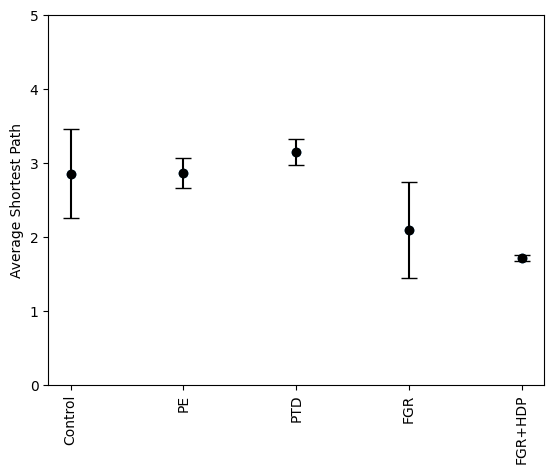

In [12]:
plt.plot(list_avg_short_path, marker='o', linestyle='')
plt.errorbar([0,1,2,3,4], list_avg_short_path, yerr=list_avg_short_path_sd, fmt="o", color='black', capsize=6)
plt.xticks(ticks=range(0, len(list_avg_short_path)),labels=LABELS_GROUPS, rotation=90)
plt.ylim((0,5))
plt.ylabel('Average Shortest Path')
plt.savefig("../output/CommunityConservationAnalysis/average_shortest_path_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [13]:
# calculate average shortest path length
list_degree_centrality = []
list_degree_centrality_sd = []

print('Average Degree Centrality:\n')
print('Control')
avg, sd = calc_avg_degree_centrality(g_control, 'Control')
list_degree_centrality.append(avg)
list_degree_centrality_sd.append(avg)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

print('PE')
avg, sd = calc_avg_degree_centrality(g_severe_pe, 'PE')
list_degree_centrality.append(avg)
list_degree_centrality_sd.append(avg)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

print('PTD')
avg, sd = calc_avg_degree_centrality(g_ptd, 'PTD')
list_degree_centrality.append(avg)
list_degree_centrality_sd.append(avg)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

print('FGR')
avg, sd = calc_avg_degree_centrality(g_fgr, 'FGR')
list_degree_centrality.append(avg)
list_degree_centrality_sd.append(avg)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

print('FGR+HDP')
avg, sd = calc_avg_degree_centrality(g_fgr_hyp, 'FGR+HDP')
list_degree_centrality.append(avg)
list_degree_centrality_sd.append(avg)
print('Average:', str(round(avg,3)))
print('Std Dev:', str(round(sd,3)), '\n')

Average Degree Centrality:

Control
Average Degree Centrality For Communities in Control
Average: 0.079
Std Dev: 0.221 

PE
Average Degree Centrality For Communities in PE
Average: 0.01
Std Dev: 0.064 

PTD
Average Degree Centrality For Communities in PTD
Average: 0.01
Std Dev: 0.063 

FGR
Average Degree Centrality For Communities in FGR
Average: 0.299
Std Dev: 0.358 

FGR+HDP
Average Degree Centrality For Communities in FGR+HDP
Average: 0.32
Std Dev: 0.233 



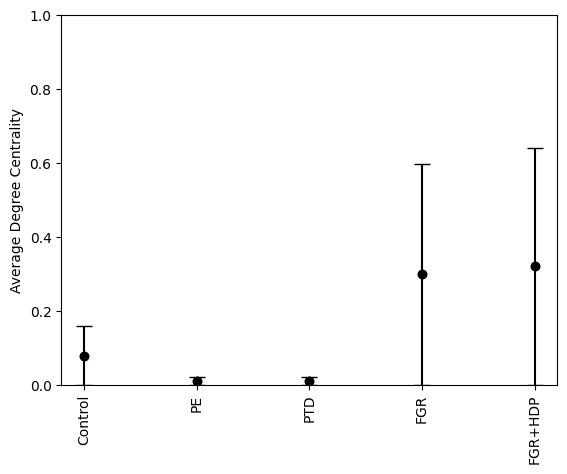

In [14]:
plt.plot(list_degree_centrality, marker='o', linestyle='')
plt.errorbar([0,1,2,3,4], list_degree_centrality, yerr=list_degree_centrality_sd, fmt="o", color='black', capsize=6)
plt.xticks(ticks=range(0, len(list_degree_centrality)),labels=LABELS_GROUPS, rotation=90)
plt.ylim((0,1))
plt.ylabel('Average Degree Centrality')
plt.savefig("../output/CommunityConservationAnalysis/average_degree_centrality_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
# calculate the clustering coefficient
list_clustering_coeff = []

print('Average Clustering Coefficient:\n')
mod = nx.average_clustering(g_control)
list_clustering_coeff.append(mod)
print('Control:', str(round(mod,3)))

mod = nx.average_clustering(g_severe_pe)
list_clustering_coeff.append(mod)
print('PE:', str(round(mod,3)))

mod = nx.average_clustering(g_ptd)
list_clustering_coeff.append(mod)
print('PTD:', str(round(mod,3)))

mod = nx.average_clustering(g_fgr)
list_clustering_coeff.append(mod)
print('FGR:', str(round(mod,3)))

mod = nx.average_clustering(g_fgr_hyp)
list_clustering_coeff.append(mod)
print('FGR+HDP:', str(round(mod,3)))

Average Clustering Coefficient:

Control: 0.017
PE: 0.01
PTD: 0.011
FGR: 0.0
FGR+HDP: 0.494


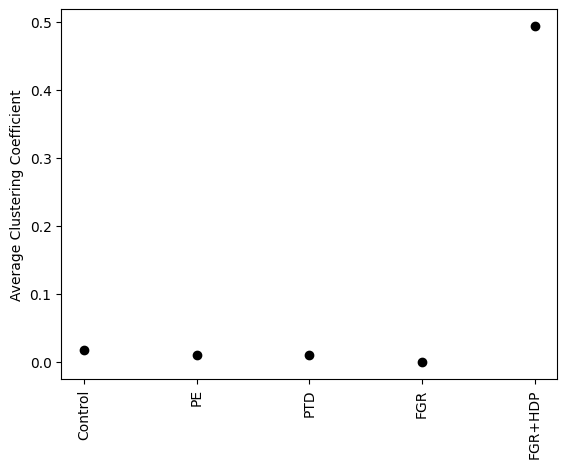

In [16]:
plt.plot(list_clustering_coeff, marker='o', linestyle='', color='black')
plt.xticks(ticks=range(0, len(list_clustering_coeff)),labels=LABELS_GROUPS, rotation=90)
plt.ylabel('Average Clustering Coefficient')
plt.savefig("../output/CommunityConservationAnalysis/average_clustering_coefficient_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [17]:
# calculate the partition quality following louvain community analysis
list_partition_coverage = []
list_partition_performance = []

print('Partition Quality:\n')
coverage, performance = calc_partition_quality(g_control, 'Control')
list_partition_coverage.append(coverage)
list_partition_performance.append(performance)

coverage, performance = calc_partition_quality(g_severe_pe, 'PE')
list_partition_coverage.append(coverage)
list_partition_performance.append(performance)

coverage, performance = calc_partition_quality(g_ptd, 'PTD')
list_partition_coverage.append(coverage)
list_partition_performance.append(performance)

coverage, performance = calc_partition_quality(g_fgr, 'FGR')
list_partition_coverage.append(coverage)
list_partition_performance.append(performance)

coverage, performance = calc_partition_quality(g_fgr_hyp, 'FGR+HDP')
list_partition_coverage.append(coverage)
list_partition_performance.append(performance)

Partition Quality:

Control Coverage: 0.949272165857962
Control Performance: 0.7281253483964473


PE Coverage: 0.8407905850554649
PE Performance: 0.4166384199339144


PTD Coverage: 0.9783115545193298
PTD Performance: 0.5723621554094721


FGR Coverage: 0.9896907216494846
FGR Performance: 0.881127708815485


FGR+HDP Coverage: 1.0
FGR+HDP Performance: 0.322289925787987




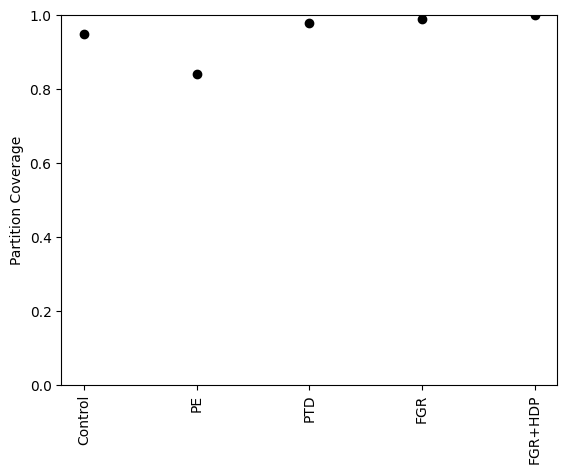

In [18]:
plt.plot(list_partition_coverage, marker='o', linestyle='', color='black')
plt.xticks(ticks=range(0, len(list_partition_coverage)),labels=LABELS_GROUPS, rotation=90)
plt.ylabel('Partition Coverage')
plt.ylim(0,1)
plt.savefig("../output/CommunityConservationAnalysis/partition_coverage_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()

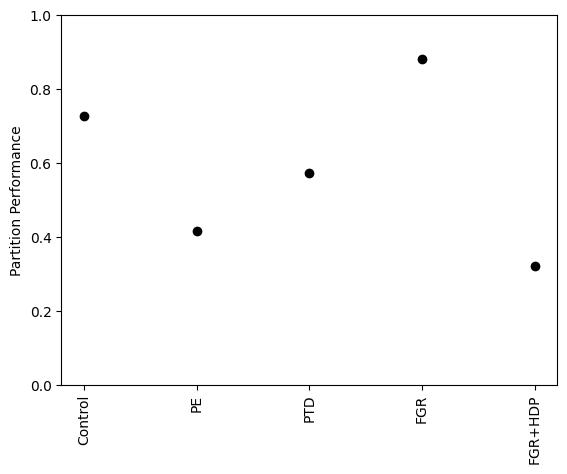

In [19]:
plt.plot(list_partition_performance, marker='o', linestyle='', color='black')
plt.xticks(ticks=range(0, len(list_partition_performance)),labels=LABELS_GROUPS, rotation=90)
plt.ylabel('Partition Performance')
plt.ylim(0,1)
plt.savefig("../output/CommunityConservationAnalysis/partition_performance_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [20]:
# calculate modularity
list_mod = []

print('Modularity:\n')
modularity_control = calculate_modularity(g_control)
list_mod.append(modularity_control)
print('Control:', str(modularity_control))

modularity_pe = calculate_modularity(g_severe_pe)
list_mod.append(modularity_pe)
print('PE:', str(modularity_pe))

modularity_ptd = calculate_modularity(g_ptd)
list_mod.append(modularity_ptd)
print('PTD:', str(modularity_ptd))

modularity_fgr = calculate_modularity(g_fgr)
list_mod.append(modularity_fgr)
print('FGR:', str(modularity_fgr))

modularity_fgr_hyp = calculate_modularity(g_fgr_hyp)
list_mod.append(modularity_fgr_hyp)
print('FGR+HDP:', str(modularity_fgr_hyp))

Modularity:

Control: 0.8
PE: 0.62
PTD: 0.77
FGR: 0.9
FGR+HDP: 0.55


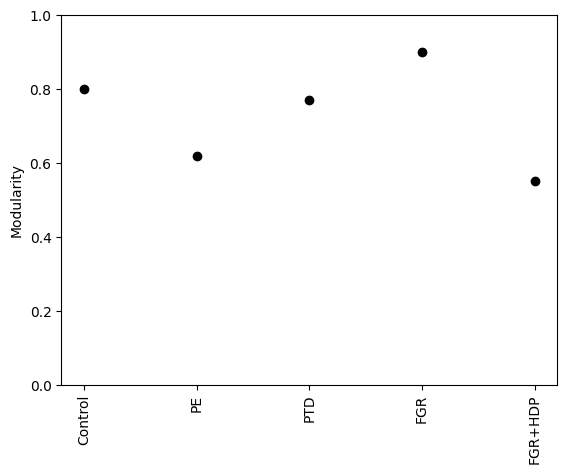

In [21]:
plt.plot(list_mod, marker='o', linestyle='', color='black')
plt.xticks(ticks=range(0, len(list_mod)),labels=LABELS_GROUPS, rotation=90)
plt.ylim((0,1))
plt.ylabel('Modularity')
plt.savefig("../output/CommunityConservationAnalysis/modularity_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [22]:
# calculate modularity differences
mod_diff = []

print('Modularity Difference:\n')

score = calc_difference(modularity_control, modularity_pe)
mod_diff.append(score)
print('Control vs. PE:', str(score))

score = calc_difference(modularity_control, modularity_ptd)
mod_diff.append(score)
print('Control vs. PTD:', str(score))

score = calc_difference(modularity_control, modularity_fgr)
mod_diff.append(score)
print('Control vs. FGR:', str(score))

score = calc_difference(modularity_control, modularity_fgr_hyp)
mod_diff.append(score)
print('Control vs. FGR+HDP:', str(score))

score = calc_difference(modularity_pe, modularity_ptd)
mod_diff.append(score)
print('PE vs. PTD:', str(score))

score = calc_difference(modularity_pe, modularity_fgr)
mod_diff.append(score)
print('PE vs. FGR:', str(score))

score = calc_difference(modularity_pe, modularity_fgr_hyp)
mod_diff.append(score)
print('PE vs. FGR+HDP:', str(score))

score = calc_difference(modularity_ptd, modularity_fgr)
mod_diff.append(score)
print('PTD vs. FGR:', str(score))

score = calc_difference(modularity_ptd, modularity_fgr_hyp)
mod_diff.append(score)
print('PTD vs. FGR+HDP:', str(score))

score = calc_difference(modularity_fgr, modularity_fgr_hyp)
mod_diff.append(score)
print('FGR vs. FGR+HDP:', str(score))

Modularity Difference:

Control vs. PE: 0.18
Control vs. PTD: 0.03
Control vs. FGR: -0.1
Control vs. FGR+HDP: 0.25
PE vs. PTD: -0.15
PE vs. FGR: -0.28
PE vs. FGR+HDP: 0.07
PTD vs. FGR: -0.13
PTD vs. FGR+HDP: 0.22
FGR vs. FGR+HDP: 0.35


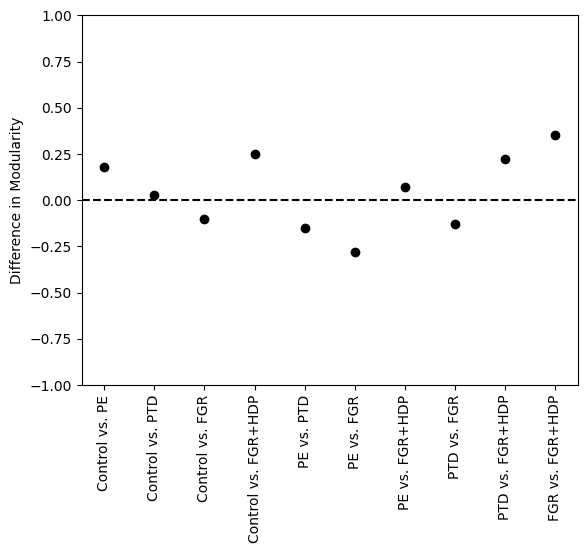

In [23]:
plt.plot(mod_diff, marker='o', linestyle='', color='black')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.xticks(ticks=range(0, len(mod_diff)),labels=LABELS_COMPARISONS, rotation=90)
plt.ylim((-1,1))
plt.ylabel('Difference in Modularity')
plt.savefig("../output/CommunityConservationAnalysis/modularity_difference_all_communities.pdf", format="pdf", bbox_inches="tight")
plt.show()